In [106]:
import HomeMade as hm
import numpy as np
import matplotlib.pyplot as plt
import uproot
import importlib
hm = importlib.reload(hm)
import pandas as pd

%matplotlib inline

In [2]:
path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(entrystop = 1)
for feat in data.columns:
    print(feat)

eventCounter
npv
ntrk_pv0
pv0_x
pv0_y
pv0_z
a0xy
a0
a0z
cosTheta
v0_chi2
v0_x
v0_y
v0_z
v0_rxy
v0_rxyErr
v0_px
v0_py
v0_pz
v0_pt
v0_p
v0_ptErr
v0_ks_mass
v0_la_mass
v0_lb_mass
v0_ks_massErr
v0_la_massErr
v0_lb_massErr
v0_px1
v0_py1
v0_pz1
v0_pt1
v0_p1
v0_px2
v0_py2
v0_pz2
v0_pt2
v0_p2
v0_phi1
v0_theta1
v0_qOverP1
v0_phi2
v0_theta2
v0_qOverP2
alpha
calpha
epsilon1
epsilon2
Alpha
pL1
pL2
pT
thetastar
rapidity_ks
rapidity_la
rapidity_lb
pseudorapidity
numberOfPixelHits1
numberOfSCTHits1
numberOfTRTHits1
numberOfTRTHighThresholdHits1
numberOfBLayerHits1
expectBLayerHit1
numberOfInnermostPixelLayerHits1
expectInnermostPixelLayerHit1
numberOfPixelHits2
numberOfSCTHits2
numberOfTRTHits2
numberOfTRTHighThresholdHits2
numberOfBLayerHits2
expectBLayerHit2
numberOfInnermostPixelLayerHits2
expectInnermostPixelLayerHit2
numberOfContribPixelLayers1
numberOfBLayerOutliers1
numberOfBLayerSharedHits1
numberOfBLayerSplitHits1
numberOfInnermostPixelLayerOutliers1
numberOfInnermostPixelLayerSharedHits1
nu

In [3]:
N = 1e7
list_of_features = "v0_ks_mass v0_ks_massErr".split(" ")

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(list_of_features,entrystop = N)

# path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
# file = uproot.open(path)
# mc = file['tree'].pandas.df(list_of_features+['trueLa'],entrystop = N)

data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]

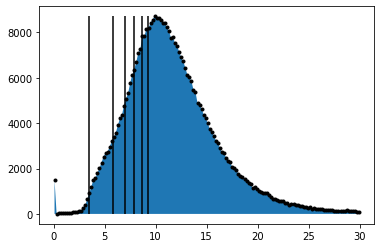

In [143]:
vals, binc, binw = hm.hist(data.v0_ks_massErr,bins=150,range=(0,30))
fig, ax = plt.subplots()
ax.fill_between(binc,vals)
ax.plot(binc,vals,'k.')

tmp_err = data.v0_ks_massErr.loc[(data.v0_ks_massErr>=3.5)&(data.v0_ks_massErr<=9.7)].sort_values().reset_index(drop=True)
err_ranges = tmp_err[np.arange(0,len(tmp_err),25000)].to_numpy()#.append(pd.Series(25)).reset_index(drop=True)

for loc in err_ranges:
    ax.vlines(loc,0,max(vals))

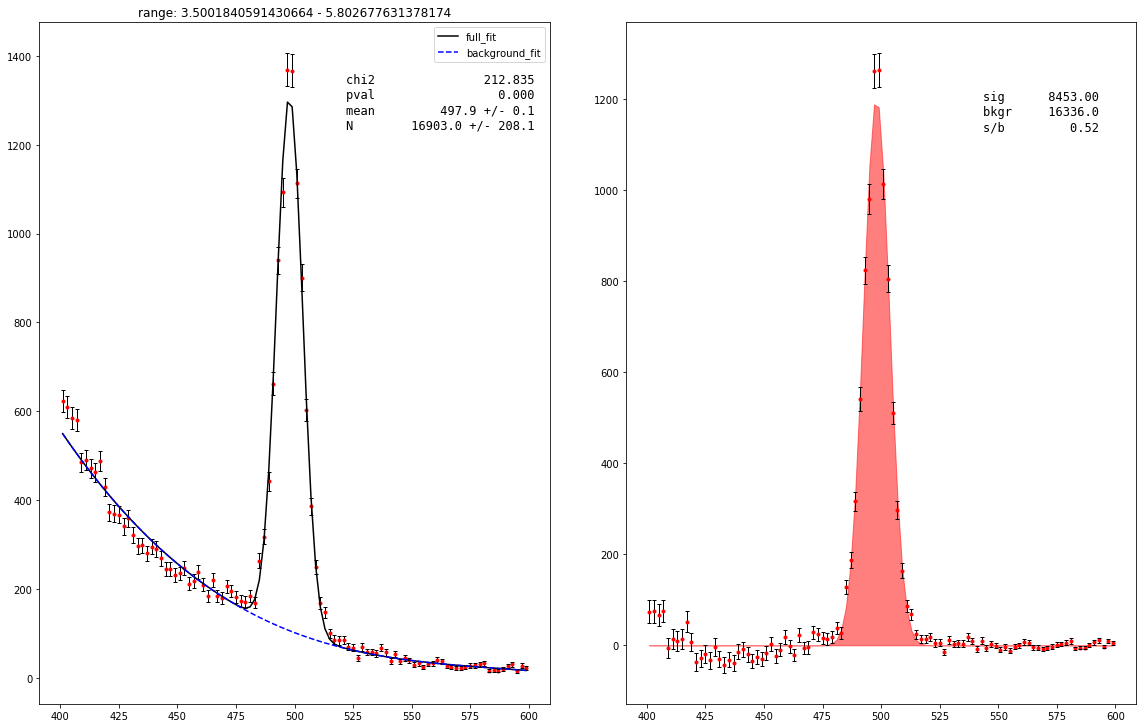

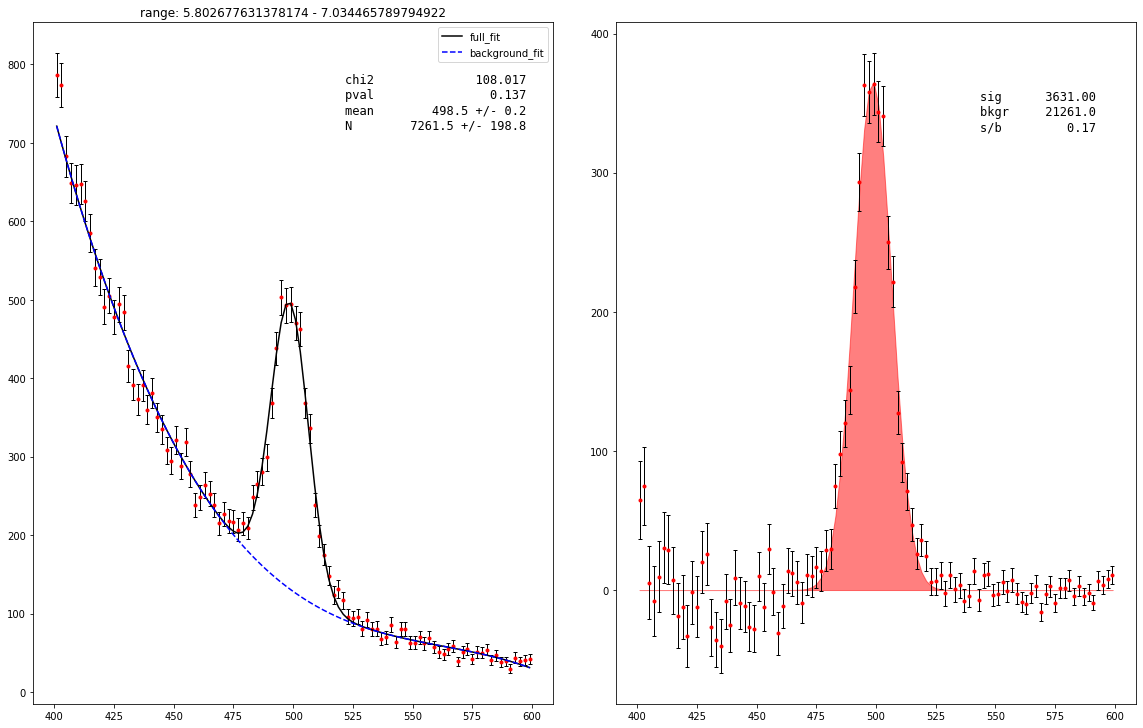

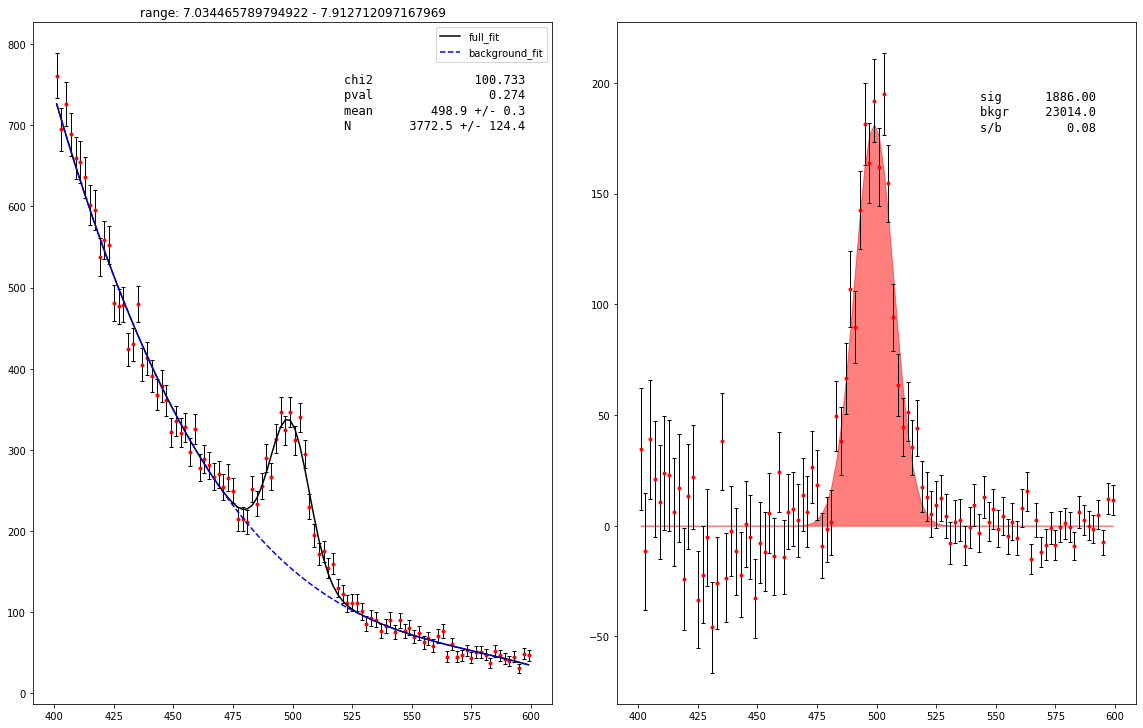

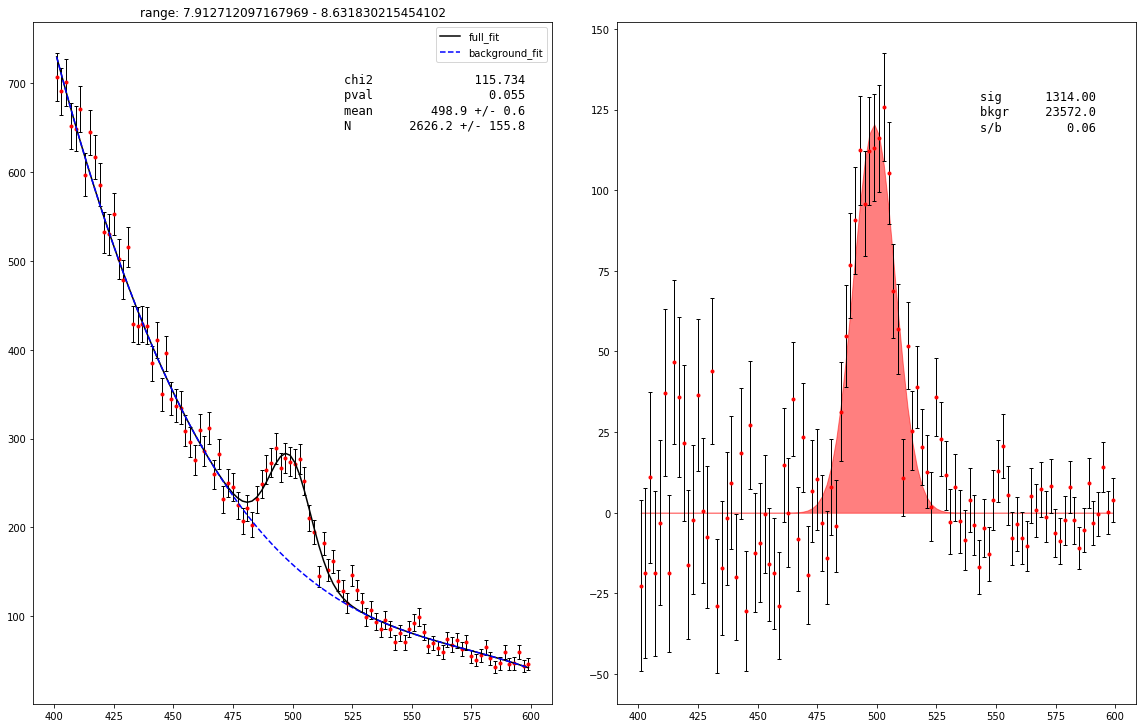

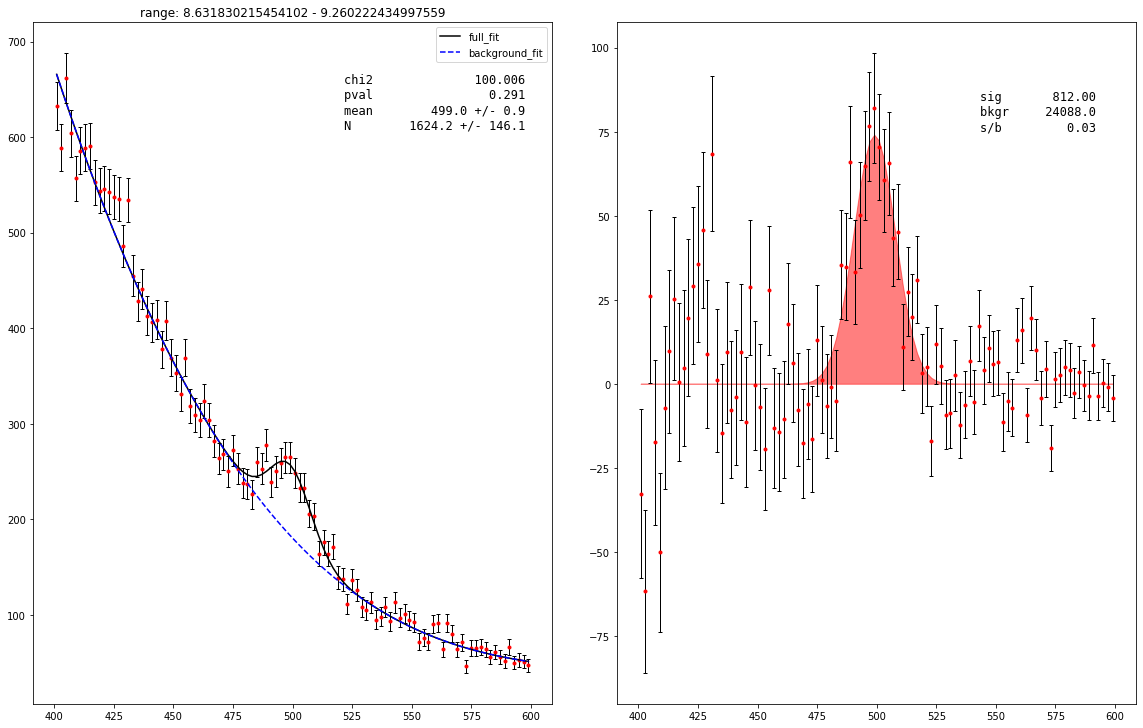

In [144]:
E_err = []
sE_err = []
O_err = []
sO_err = []

for i in range(1, len(err_ranges)):
    dat = data.loc[(data.v0_ks_massErr>=err_ranges[i-1])&(data.v0_ks_massErr<=err_ranges[i])]
    vals, binc, binw = hm.hist(dat.v0_ks_mass,bins=100)
    fig, ax, M, sigF, bkgrF, params = hm.fit_mass(binc,vals,np.sqrt(vals))
    ax[0].set_title(f'range: {err_ranges[i-1]} - {err_ranges[i]}')
    
    E_err.append(dat.v0_ks_massErr.mean())
    sE_err.append(dat.v0_ks_massErr.std())
    
    migrad_counter = 0
    while not M.accurate and migrad_counter < 10:
        M.migrad()
        migrad_counter += 1
    if not M.accurate: print('Fitted error is not accurate!')
    
    
    O_err.append(M.values['sig'])
    sO_err.append(M.errors['sig'])

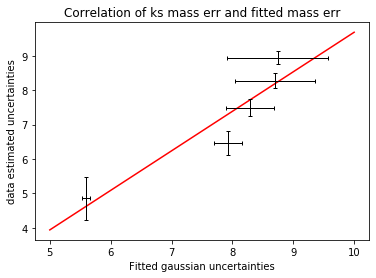

In [185]:
from iminuit import Minuit
from AppStatFunctions import Chi2Regression

fig, ax = plt.subplots()
ax.set(xlabel='Fitted gaussian uncertainties',ylabel='data estimated uncertainties',
      title='Correlation of ks mass err and fitted mass err')

def linfitfunc(x,a,b):
    return a*x + b

M = Minuit(Chi2Regression(linfitfunc,O_err,E_err,sE_err,1/np.array(sO_err)),pedantic = False)
# M = Minuit(Chi2Regression(linfitfunc,O_err,E_err,sE_err),pedantic = False)
M.migrad()

ax.errorbar(O_err,E_err,sE_err,sO_err,color = 'k', elinewidth = 1, capsize = 2,ls='None')
# ax.plot([5,9],[5,9],ls='--')
ax.plot([5,10],linfitfunc(np.array([5,10]),*M.args),'r',zorder=-1)

In [186]:
from scipy.stats import chi2
chi2.sf(M.fval, len(O_err) - len(M.args))

3.675845802120046e-10

In [193]:
path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(list_of_features+['trueLa'],entrystop = N)

mc = mc.loc[(mc.v0_ks_mass > 400) & (mc.v0_ks_mass < 600)]

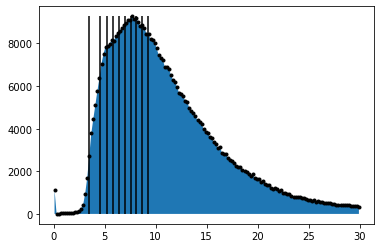

In [194]:
vals, binc, binw = hm.hist(mc.v0_ks_massErr,bins=150,range=(0,30))
fig, ax = plt.subplots()
ax.fill_between(binc,vals)
ax.plot(binc,vals,'k.')

tmp_err = mc.v0_ks_massErr.loc[(mc.v0_ks_massErr>=3.5)&(mc.v0_ks_massErr<=9.7)].sort_values().reset_index(drop=True)
err_ranges = tmp_err[np.arange(0,len(tmp_err),25000)].to_numpy()#.append(pd.Series(25)).reset_index(drop=True)

for loc in err_ranges:
    ax.vlines(loc,0,max(vals))

C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


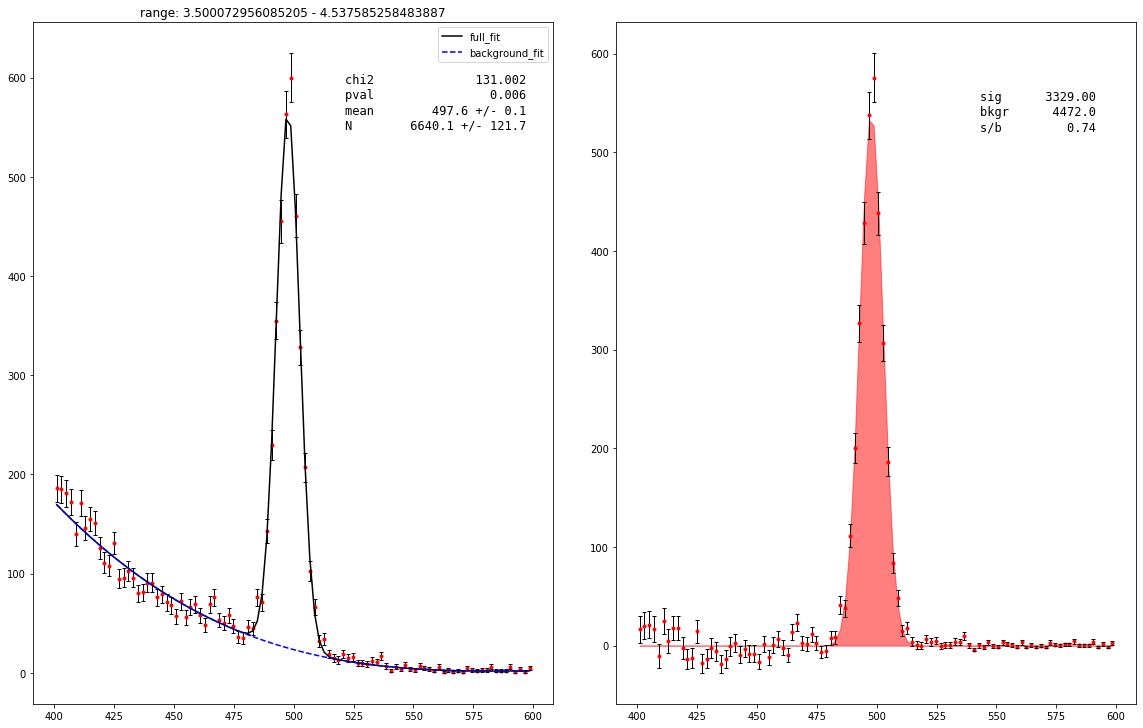

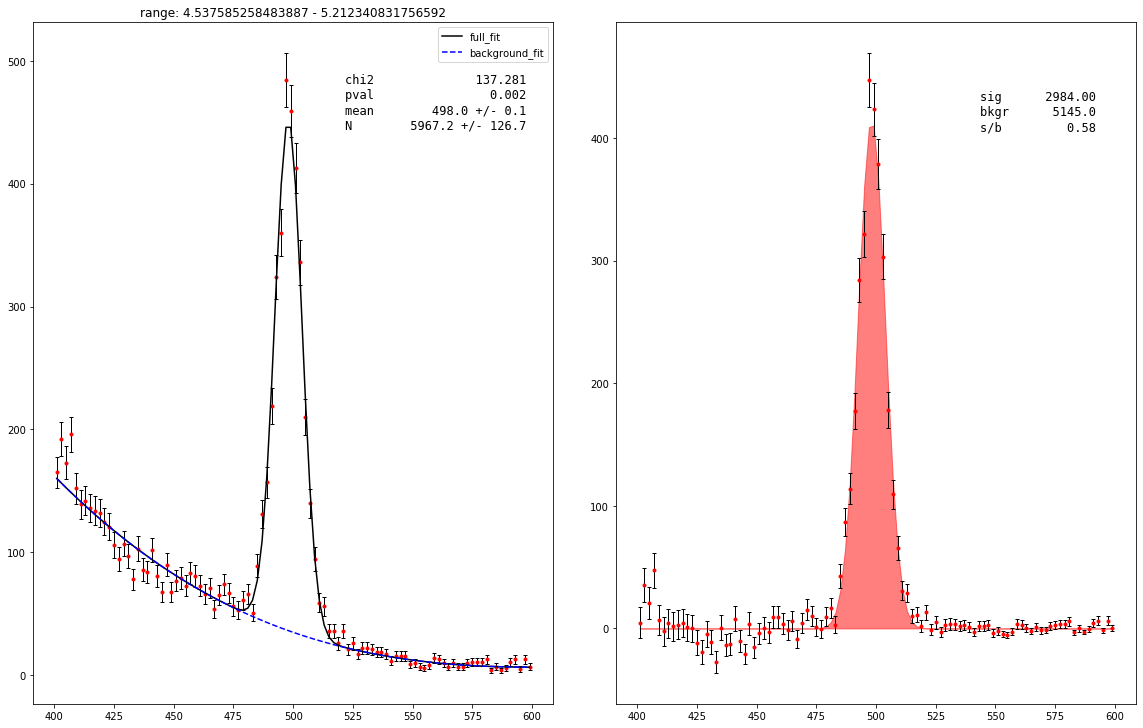

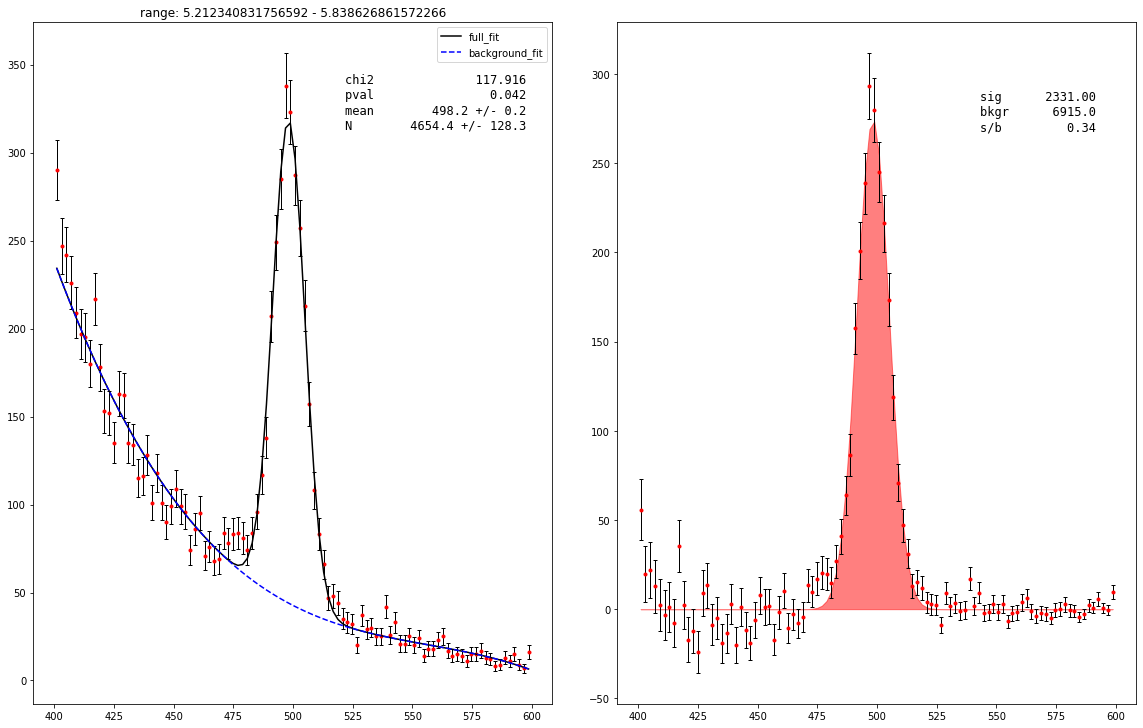

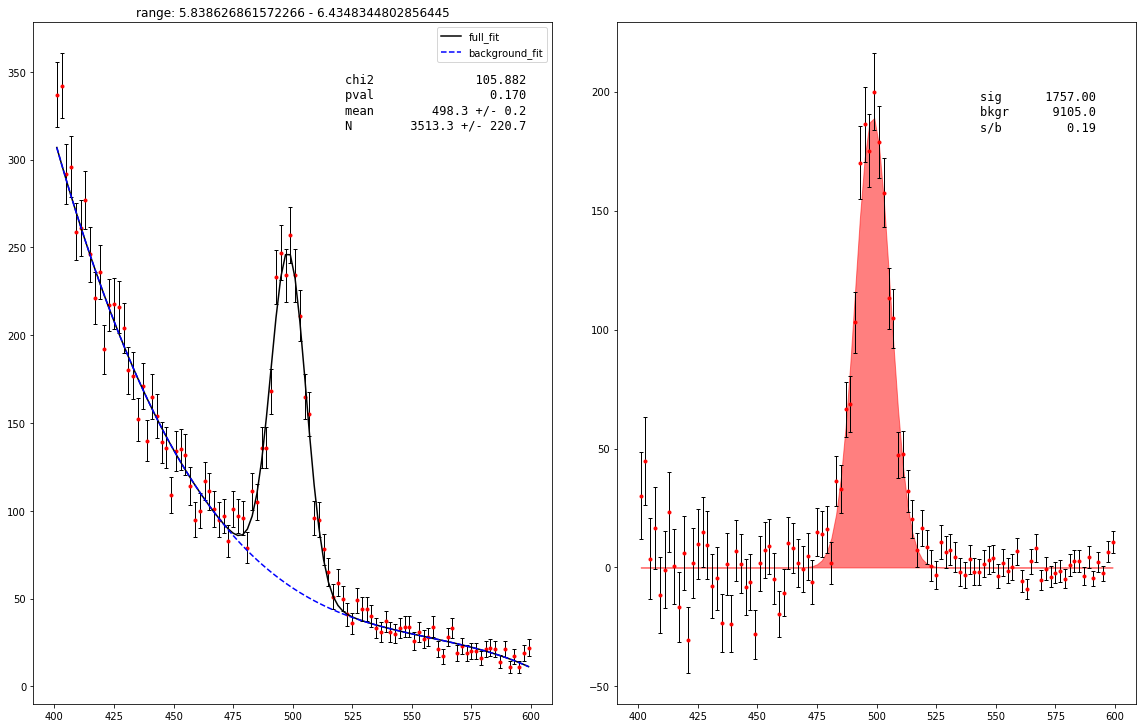

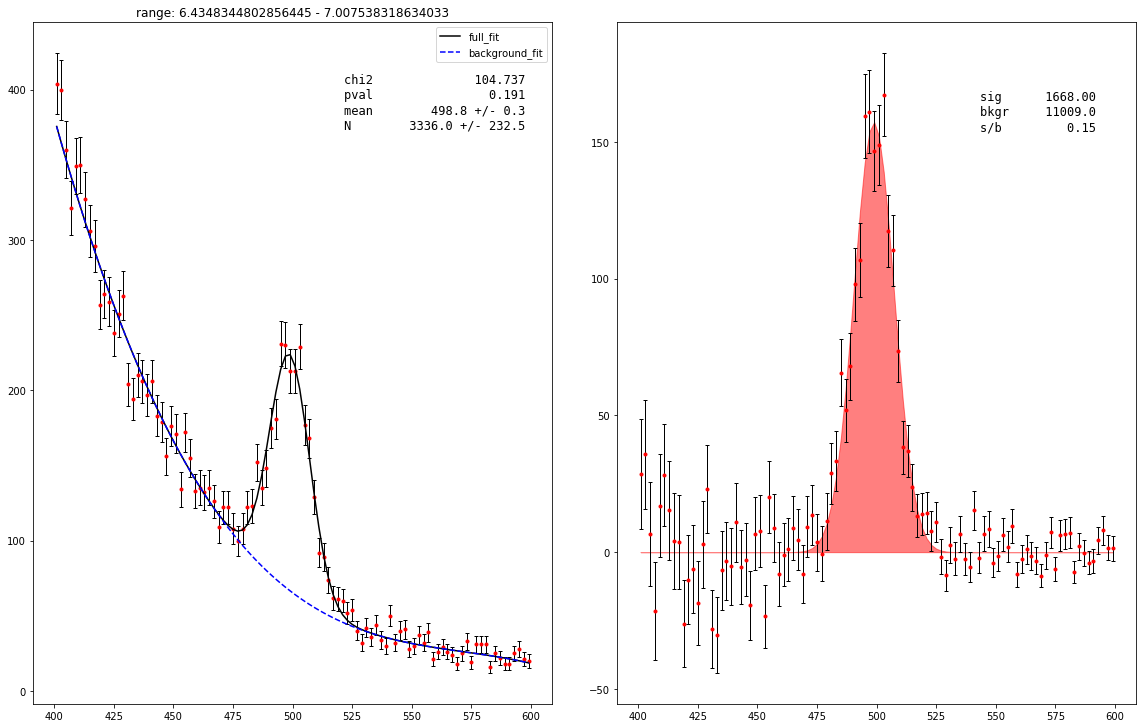

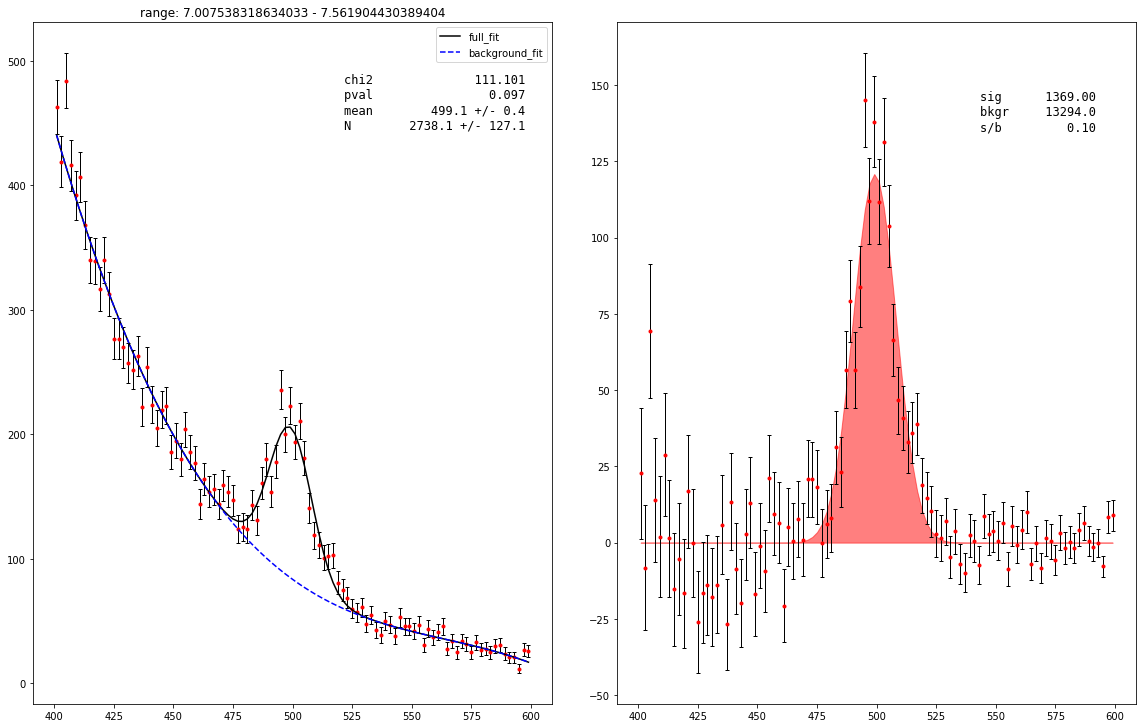

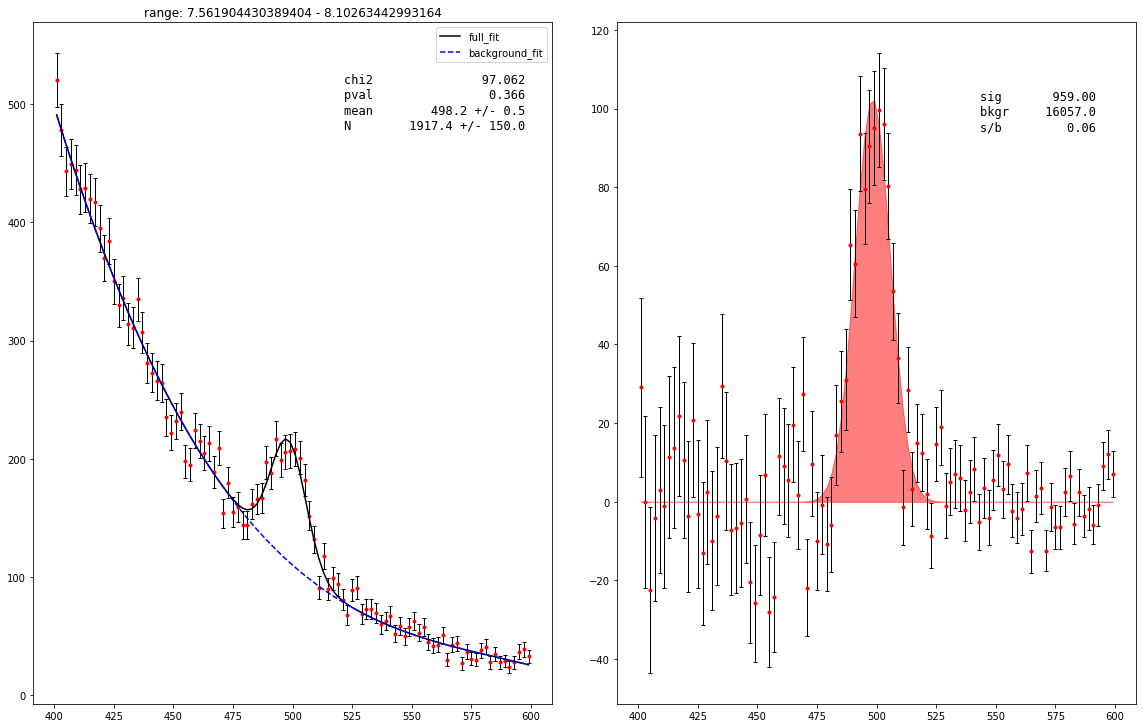

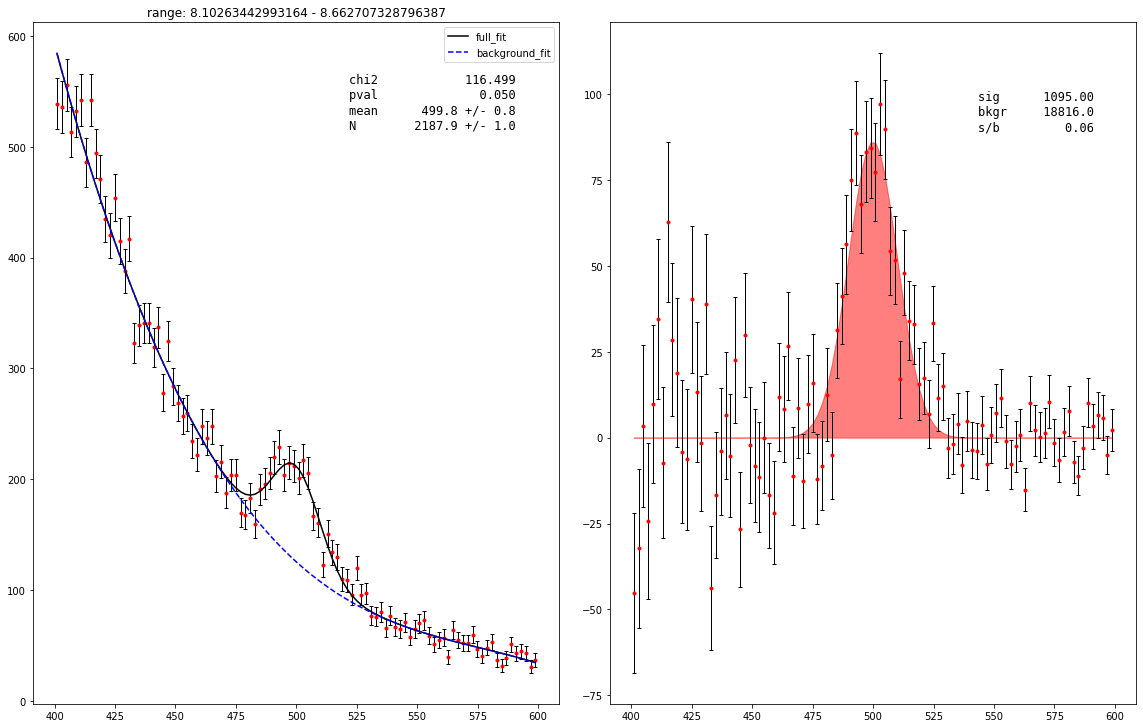

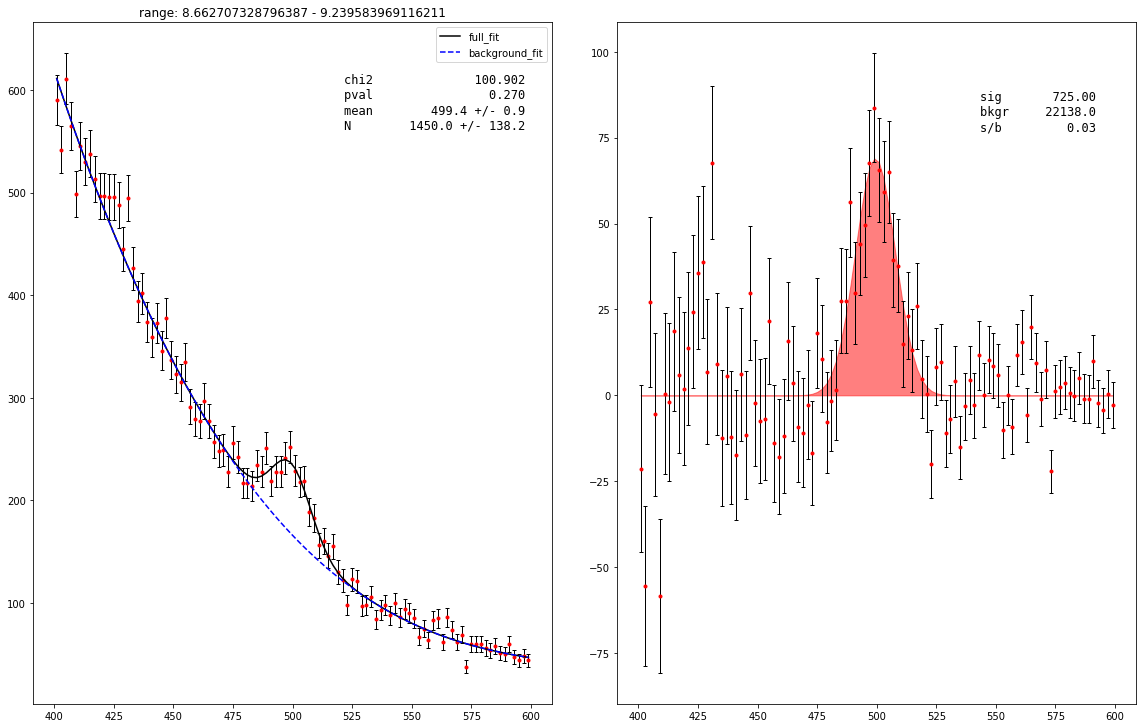

In [195]:
E_err = []
sE_err = []
O_err = []
sO_err = []

for i in range(1, len(err_ranges)):
    dat = data.loc[(data.v0_ks_massErr>=err_ranges[i-1])&(data.v0_ks_massErr<=err_ranges[i])]
    vals, binc, binw = hm.hist(dat.v0_ks_mass,bins=100)
    mask = vals>0
    fig, ax, M, sigF, bkgrF, params = hm.fit_mass(binc[mask],vals[mask],np.sqrt(vals[mask]))
    ax[0].set_title(f'range: {err_ranges[i-1]} - {err_ranges[i]}')
    
    E_err.append(dat.v0_ks_massErr.mean())
    sE_err.append(dat.v0_ks_massErr.std())
    
    migrad_counter = 0
    while not M.accurate and migrad_counter < 10:
        M.migrad()
        migrad_counter += 1
    if not M.accurate: print('Fitted error is not accurate!')
    
    
    O_err.append(M.values['sig'])
    sO_err.append(M.errors['sig'])

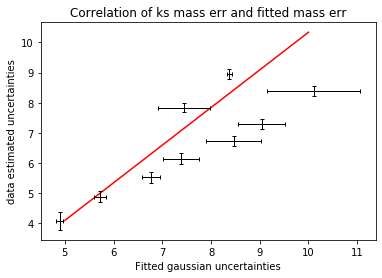

In [196]:
from iminuit import Minuit
from AppStatFunctions import Chi2Regression

fig, ax = plt.subplots()
ax.set(xlabel='Fitted gaussian uncertainties',ylabel='data estimated uncertainties',
      title='Correlation of ks mass err and fitted mass err')

def linfitfunc(x,a,b):
    return a*x + b

M = Minuit(Chi2Regression(linfitfunc,O_err,E_err,sE_err,1/np.array(sO_err)),pedantic = False)
# M = Minuit(Chi2Regression(linfitfunc,O_err,E_err,sE_err),pedantic = False)
M.migrad()

ax.errorbar(O_err,E_err,sE_err,sO_err,color = 'k', elinewidth = 1, capsize = 2,ls='None')
# ax.plot([5,9],[5,9],ls='--')
ax.plot([5,10],linfitfunc(np.array([5,10]),*M.args),'r',zorder=-1)